In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: False
Device count: 0
Device name: CPU


In [ ]:
#DO NOT RUN THIS AS PART OF THE GAME
#This first block is only for generating a useable structure for the game.
#This code takes 20 hours to complete!!! (30 seconds determing 10 category ratings per noun).

import torch
import ast
import json
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# -------------------------------
# Load tokenizer and 8-bit model
# -------------------------------
model_name = "microsoft/Phi-3-mini-4k-instruct"

print("Loading tokenizer and 8-bit model...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 8-bit quantization for VRAM savings and speed
bnb_config = BitsAndBytesConfig(load_in_8bit=True)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",          # automatically maps layers to GPU
    quantization_config=bnb_config,
    trust_remote_code=False,
)
model.eval()  # inference mode

print("Model loaded in 8-bit on device:", next(model.parameters()).device)
print("VRAM allocated (bytes):", torch.cuda.memory_allocated(), "reserved:", torch.cuda.memory_reserved())

# -------------------------------
# Load nouns from file
# -------------------------------
nouns = []
#with open("test_nouns.txt", "r", encoding="utf-8") as f:
with open("noun_universe.txt", "r", encoding="utf-8") as f:
    for line in f:
        word = line.strip()
        if word:
            nouns.append(word)
print(f"Loaded {len(nouns)} nouns")

# -------------------------------
# Helper: extract only the first dictionary
# -------------------------------
def extract_first_dict(text):
    """Keep only the first {...} in the text."""
    start = text.find("{")
    if start == -1:
        return ""
    stack = 0
    for i, c in enumerate(text[start:], start):
        if c == "{":
            stack += 1
        elif c == "}":
            stack -= 1
            if stack == 0:
                return text[start:i+1]
    return text[start:]  # fallback

# -------------------------------
# Process nouns one by one
# -------------------------------
noun_structures = []

for noun in nouns:
    print("processing noun:", noun)

    # --- Original prompt preserved exactly + stricter instructions ---
    full_prompt = (
        "You are an expert at categorizing nouns. You need to return to me a dictionary structure in python where the noun "
        "that I give you contains a true or false value for various category questions. The questions are "
        "1.) Is it alive? This answer should be stored in boolean variable is_alive. "
        "2.) Is it an person? This answer should be stored in boolean variable is_person? "
        "3.) Is it a place? stored in variable is_place "
        "4.) Is it a thing? stored in variable is_thing "
        "5.) Is it a plant? stored in variable is_plant "
        "6.) Is it an animal? stored in variable is_animal "
        "7.) Is it a tangible physical object? stored in variable is_physical? "
        "8.) Is it a rock or mineral? stored in is_rock "
        "9.) Is it a food? stored in is_food "
        "10.) Is it man made? stored in is_man_made. "
        "The last field in the structure should be name, where the value is just the name of the noun. "
        "IMPORTANT: Only return the dictionary for the noun given. Do NOT include any other nouns, examples, or commentary. "
        "Please output only the variable names and values within curly brackets as would appear in a python dictionary structure. "
        "Dont write anything outside of the curly brackets. The name variable must have a value that is exactly the provided noun. "
        "Do this for the noun: " + noun
    )

    # --- Tokenize and move to GPU ---
    inputs = tokenizer(full_prompt, return_tensors="pt").to(next(model.parameters()).device)

    # --- Generate output ---
    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=500,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            num_beams=1,
            use_cache=True,
        )

    # --- Decode and clean output ---
    result_text = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    clean_output = result_text.strip().removeprefix("```python").removesuffix("```").strip()

    # --- Extract only the first dictionary ---
    clean_output = extract_first_dict(clean_output)

    print(clean_output)

    # --- Convert string to dict safely ---
    try:
        noun_dict = ast.literal_eval(clean_output)
        noun_structures.append(noun_dict)
    except Exception as e:
        print(f"Error parsing output for '{noun}': {e}")

# -------------------------------
# Save results to JSON file
# -------------------------------
output_filename = "noun_structures.json"
with open(output_filename, "w", encoding="utf-8") as f:
    json.dump(noun_structures, f, indent=4)

print(f"Saved {len(noun_structures)} noun structures to {output_filename}")

Loading tokenizer and 8-bit model...


ImportError: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`

In [ ]:
#DONT NEED TO RUN THIS UNLESS THE GENERATED FILE ABOVE CHANGES
#Process the LLM output into JSON format (and clean up malformed outputs) and save to a file so that the
#category determinations for each of the nouns can be used.

import re
import json
import ast
import os

INPUT = "noun_structs.jsonl"   # change if needed
OUTPUT = "noun_structures_clean.json"
BAD_DIR = "bad_blocks"

os.makedirs(BAD_DIR, exist_ok=True)

with open(INPUT, "r", encoding="utf-8") as f:
    content = f.read()

# --- Balanced-brace extractor (more robust than a simple regex) ---
blocks = []
stack = []
start_idx = None
for i, ch in enumerate(content):
    if ch == "{":
        if not stack:
            start_idx = i
        stack.append(ch)
    elif ch == "}":
        if stack:
            stack.pop()
            if not stack and start_idx is not None:
                blocks.append(content[start_idx:i+1])
                start_idx = None

print(f"Found {len(blocks)} dictionary blocks")

noun_structures = []
failed_indices = []

def aggressive_repair(s: str) -> str:
    b = s

    # remove weird control characters (keep normal whitespace)
    b = re.sub(r"[\x00-\x08\x0b\x0c\x0e-\x1f\x7f]", " ", b)

    # fix underscore splits across newlines/spaces: is_\nphysical or is_ physical -> is_physical
    b = re.sub(r"_\s*\n\s*", "_", b)
    b = re.sub(r"_\s+", "_", b)

    # ensure there's a closing brace if missing (shouldn't happen with balanced extractor, but safe)
    if b.count("{") > b.count("}"):
        b = b + "}"

    # collapse internal repeated whitespace around colons, commas, and braces for reliability
    b = re.sub(r"[ \t]+\:", ":", b)
    b = re.sub(r"\:[ \t]+", ": ", b)
    b = re.sub(r"[ \t]+\,", ",", b)
    b = re.sub(r",\s+\}", "}", b)  # remove trailing commas before closing brace

    # convert single quotes to double quotes carefully:
    #  - first, handle keys without quotes (see below)
    #  - then replace single-quoted strings with double quotes
    # But do NOT blindly replace every single-quote because contractions or escaped quotes might exist.
    # We'll do a simple safe replacement for patterns like '...'
    b = re.sub(r"\'([^']*?)\'", r'"\1"', b)

    # normalize booleans/None for JSON parse
    b = re.sub(r"\bTrue\b", "true", b)
    b = re.sub(r"\bFalse\b", "false", b)
    b = re.sub(r"\bNone\b", "null", b)

    # Quote unquoted keys: look for key identifiers followed by colon that are not quoted
    # This looks for occurrences like  name: or  is_alive: and replaces with "name":
    def _quote_keys(text):
        # pattern: beginning-of-block or comma or whitespace, then key (letters/underscore/digits), optional spaces, colon
        pattern = re.compile(r'(?P<prefix>[\{\s,])(?P<key>[A-Za-z_][A-Za-z0-9_]*)\s*:')
        # replace with prefix "key":
        return pattern.sub(lambda m: f'{m.group("prefix")}"{m.group("key")}":', text)

    b = _quote_keys(b)

    # final cleanup: remove duplicate commas and trailing commas before closing brace
    b = re.sub(r",\s*,", ",", b)
    b = re.sub(r",\s*}", "}", b)

    # Trim
    return b.strip()

def try_parse(original: str, idx: int):
    """Try to parse block; return dict or None and save diagnostics files when failing."""
    orig = original
    # First try as-is (JSON)
    try:
        return json.loads(orig)
    except Exception:
        pass

    # Try ast.literal_eval on original (handles Python style dicts)
    try:
        val = ast.literal_eval(orig)
        return val
    except Exception:
        pass

    # Save original to disk for inspection
    with open(os.path.join(BAD_DIR, f"original_block_{idx}.txt"), "w", encoding="utf-8") as f:
        f.write(orig)

    # Aggressive repair
    repaired = aggressive_repair(orig)

    # Save repaired attempt for visibility
    with open(os.path.join(BAD_DIR, f"repaired_block_{idx}.txt"), "w", encoding="utf-8") as f:
        f.write(repaired)

    # Try JSON on repaired
    try:
        return json.loads(repaired)
    except Exception:
        pass

    # Try ast on repaired (convert json booleans back to Python)
    try:
        pystyle = repaired.replace("true", "True").replace("false", "False").replace("null", "None")
        return ast.literal_eval(pystyle)
    except Exception:
        pass

    # If still failing, record index and return None
    failed_indices.append(idx)
    return None

# Parse all blocks
for i, blk in enumerate(blocks):
    parsed = try_parse(blk, i)
    if isinstance(parsed, dict):
        noun_structures.append(parsed)
    else:
        # keep going — problem blocks have been written to bad_blocks/
        continue

print(f"✅ Parsed {len(noun_structures)} valid noun structures")
print(f"⚠️ Failed to parse {len(failed_indices)} blocks; indices saved to {BAD_DIR}/original_block_<i>.txt")

# Save cleaned JSON
with open(OUTPUT, "w", encoding="utf-8") as f:
    json.dump(noun_structures, f, indent=4)
print(f"Saved cleaned output to {OUTPUT}")

# Print first few failed indices for convenience
if failed_indices:
    print("Failed block indices (first 10):", failed_indices[:10])
    print(f"Open {BAD_DIR}/original_block_<i>.txt and repaired_block_<i>.txt to inspect and edit manually if needed.")
else:
    print("All blocks parsed successfully.")

Found 1843 dictionary blocks
✅ Parsed 1843 valid noun structures
⚠️ Failed to parse 0 blocks; indices saved to bad_blocks/original_block_<i>.txt
Saved cleaned output to noun_structures_clean.json
All blocks parsed successfully.


In [ ]:
#DO NOT RUN THIS UNLESS REGENERATING PREVIOUS DATA
#This block creates the tree structure for use in the game. THIS IS AN INTERMEDIATE STEP

class CategoryNode:
    def __init__(self, name):
        self.name = name
        self.properties = {}        # can hold stats or metadata later
        self.question_node = None   # pointer to a QuestionNode (if this category has one)
        self.noun_list = []         # used if it's a leaf node (no questions below it)

    def __repr__(self):
        return f"CategoryNode({self.name})"


class QuestionNode:
    def __init__(self, question):
        self.question = question
        self.yes = None   # pointer to a CategoryNode
        self.no = None    # pointer to a CategoryNode

    def __repr__(self):
        return f"QuestionNode({self.question})"


# ======================================
# Hardcoded tree construction begins here
# ======================================

# --- Leaf category nodes (endpoints with noun lists) ---
non_physical_things = CategoryNode("non physical things")
people = CategoryNode("people")
animals = CategoryNode("animals")
plants = CategoryNode("plants")
random_living_things = CategoryNode("random living things")
places = CategoryNode("places")
foods = CategoryNode("foods")
man_made_objects = CategoryNode("man made objects")
rocks = CategoryNode("rocks")
random_uncategorized_objects = CategoryNode("random uncategorized objects")

# --- Internal category nodes ---
physical_objects = CategoryNode("physical objects")
living_things = CategoryNode("living things")
non_living_things = CategoryNode("non living things")
non_people = CategoryNode("non people")
non_animals = CategoryNode("non animals")
non_places = CategoryNode("non places")
things = CategoryNode("things")
non_foods = CategoryNode("non-foods")
natural_things = CategoryNode("natural things")

# --- Question nodes ---
q_is_tangible = QuestionNode("Is it physically tangible?")
q_is_alive = QuestionNode("Is it alive?")
q_is_person = QuestionNode("Is it a person?")
q_is_animal = QuestionNode("Is it an animal?")
q_is_plant = QuestionNode("Is it a plant?")
q_is_place = QuestionNode("Is it a place?")
q_is_thing = QuestionNode("Is it a thing?")
q_is_food = QuestionNode("Is it a food?")
q_is_man_made = QuestionNode("Is it man made?")
q_is_rock = QuestionNode("Is it a rock or mineral?")

# ====================================
# Link everything according to the map
# ====================================

# Root node
root = q_is_tangible

# Tangible?
q_is_tangible.yes = physical_objects
q_is_tangible.no = non_physical_things

# Physical objects → Is it alive?
physical_objects.question_node = q_is_alive
q_is_alive.yes = living_things
q_is_alive.no = non_living_things

# Living things → Is it a person?
living_things.question_node = q_is_person
q_is_person.yes = people
q_is_person.no = non_people

# Non-people → Is it an animal?
non_people.question_node = q_is_animal
q_is_animal.yes = animals
q_is_animal.no = non_animals

# Non-animals → Is it a plant?
non_animals.question_node = q_is_plant
q_is_plant.yes = plants
q_is_plant.no = random_living_things

# Non-living things → Is it a place?
non_living_things.question_node = q_is_place
q_is_place.yes = places
q_is_place.no = non_places

# Non-places → Is it a thing?
non_places.question_node = q_is_thing
q_is_thing.yes = things
q_is_thing.no = non_physical_things  # loops back intentionally per spec

# Things → Is it a food?
things.question_node = q_is_food
q_is_food.yes = foods
q_is_food.no = non_foods

# Non-foods → Is it man made?
non_foods.question_node = q_is_man_made
q_is_man_made.yes = man_made_objects
q_is_man_made.no = natural_things

# Natural things → Is it a rock or mineral?
natural_things.question_node = q_is_rock
q_is_rock.yes = rocks
q_is_rock.no = random_uncategorized_objects

# ====================================
# Tree summary helper (for inspection)
# ====================================
def print_tree(node, depth=0):
    indent = "  " * depth
    if isinstance(node, QuestionNode):
        print(f"{indent}Q: {node.question}")
        print(f"{indent}  Yes → {node.yes.name}")
        print(f"{indent}  No  → {node.no.name}")
        print_tree(node.yes, depth + 1)
        print_tree(node.no, depth + 1)
    elif isinstance(node, CategoryNode):
        if node.question_node:
            print(f"{indent}Category: {node.name}")
            print_tree(node.question_node, depth + 1)
        else:
            print(f"{indent}Category: {node.name} [Leaf]")

# Uncomment to visualize structure
#print_tree(root)


#*******************************************************************************************************************************
#Now that the tree structure has been created, populate the noun lists of each of the category leaf nodes with nouns that fit into
#that category.

import json

# ==========================================
# Load noun structures from previous step
# ==========================================
with open("noun_structures_clean.json", "r") as f:
    noun_data = json.load(f)

print(f"Loaded {len(noun_data)} noun structures.")

# ==========================================
# Populate the leaf nodes
# ==========================================

for noun in noun_data:
    try:
        name = noun["name"].strip()

        # --- 1. Non-physical things ---
        if not noun.get("is_physical", False):
            non_physical_things.noun_list.append(name)

        # --- 2. People ---
        if noun.get("is_person", False):
            people.noun_list.append(name)

        # --- 3. Animals ---
        if noun.get("is_animal", False):
            animals.noun_list.append(name)

        # --- 4. Plants ---
        if noun.get("is_plant", False):
            plants.noun_list.append(name)

        # --- 5. Places ---
        if noun.get("is_place", False):
            places.noun_list.append(name)

        # --- 6. Foods ---
        if noun.get("is_food", False):
            foods.noun_list.append(name)

        # --- 7. Man-made objects ---
        if noun.get("is_man_made", False):
            man_made_objects.noun_list.append(name)

        # --- 8. Rocks ---
        if noun.get("is_rock", False):
            rocks.noun_list.append(name)

        # --- 9. Random living things ---
        if (
            noun.get("is_alive", False)
            and not noun.get("is_plant", False)
            and not noun.get("is_animal", False)
            and not noun.get("is_person", False)
        ):
            random_living_things.noun_list.append(name)

        # --- 10. Random uncategorized objects ---
        if (
            not noun.get("is_alive", False)
            and not noun.get("is_food", False)
            and not noun.get("is_man_made", False)
            and not noun.get("is_rock", False)
            and not noun.get("is_place", False)
        ):
            random_uncategorized_objects.noun_list.append(name)

    except Exception as e:
        print(f"Error processing noun: {noun} -> {e}")


# ==========================================
# Summary report
# ==========================================
def summarize_category(node):
    print(f"{node.name}: {len(node.noun_list)} nouns")

print("\n=== Category Summary ===")
for cat in [
    non_physical_things,
    people,
    animals,
    plants,
    random_living_things,
    places,
    foods,
    man_made_objects,
    rocks,
    random_uncategorized_objects,
]:
    summarize_category(cat)


# Optional: Write results to file for inspection
all_category_data = {
    "non_physical_things": non_physical_things.noun_list,
    "people": people.noun_list,
    "animals": animals.noun_list,
    "plants": plants.noun_list,
    "random_living_things": random_living_things.noun_list,
    "places": places.noun_list,
    "foods": foods.noun_list,
    "man_made_objects": man_made_objects.noun_list,
    "rocks": rocks.noun_list,
    "random_uncategorized_objects": random_uncategorized_objects.noun_list,
}

with open("categorized_nouns.json", "w") as f:
    json.dump(all_category_data, f, indent=2)

print("\n✅ Categorized noun lists saved to 'categorized_nouns.json'")



#*****************************************************************************************************************************
#Add properties to the leaf nodes for each category

non_physical_things.properties = {
    "has": ["complexity"],
    "is": ["a concept"]
}

# 2.) People
people.properties = {
    "has": ["entertainment", "influence", "scientific impact", "athletic ability", "medical knowledge", "sports scoring ability"],
    "is": ["actor", "athlete", "STEM worker", "profession"]
}

# 3.) Animals
animals.properties = {
    "has": ["size", "speed", "aggressiveness", "domesticatability"],
    "is": ["mammal", "bird", "reptile", "fish", "amphibian"]
}

# 4.) Plants
plants.properties = {
    "has": ["size", "beauty", "leaves", "fruit"],
    "is": ["flower", "tree", "general plant or bush"]
}

# 5.) Random living things
random_living_things.properties = {
    "has": ["size", "speed"],
    "is": ["air breathing", "water breathing"]
}

# 6.) Places
places.properties = {
    "has": ["heat", "extreme weather", "size", "cold", "population", "vegetation"],
    "is": ["In the US", "In the western US", "In the Eastern US", "One Specific Place"]
}

# 7.) Foods
foods.properties = {
    "has": ["heat", "preparation time", "ingredients", "savoriness", "sweetness", "saltiness"],
    "is": ["natural", "cooked", "raw"]
}

# 8.) Man-made objects
man_made_objects.properties = {
    "has": ["softness", "engineering", "electrical", "size", "monetary value", "simplicity"],
    "is": ["tool", "vehicle", "toy", "service", "exercise", "clothing"]
}

# 9.) Rocks
rocks.properties = {
    "has": ["hardness", "brittleness", "shine", "beauty", "darkness", "monetary value"],
    "is": ["rock", "mineral", "metal"]
}

# 10.) Random uncategorized objects
random_uncategorized_objects.properties = {
    "has": ["size", "complexity", "entertainment"],
    "is": ["tool", "vehicle", "toy", "pokemon", "concept"]
}

# ==========================================
# Optional: verify properties
# ==========================================
def print_leaf_properties(node):
    print(f"Category: {node.name}")
    print(f"  has: {node.properties['has']}")
    print(f"  is: {node.properties['is']}\n")

for leaf in [
    non_physical_things,
    people,
    animals,
    plants,
    random_living_things,
    places,
    foods,
    man_made_objects,
    rocks,
    random_uncategorized_objects,
]:
    print_leaf_properties(leaf)

Loaded 1843 noun structures.
Error processing noun: {'island': {'is_alive': False, 'is_person': False, 'is_place': True, 'is_thing': True, 'is_plant': False, 'is_animal': False, 'is_physical': True, 'is_rock': False, 'is_food': False, 'is_man_made': False, 'name': 'island'}} -> 'name'
Error processing noun: {'mt07': {'name': 'mt07', 'is_alive': False, 'is_person': False, 'is_place': False, 'is_thing': True, 'is_plant': False, 'is_animal': False, 'is_physical': True, 'is_rock': False, 'is_food': False, 'is_man_made': False}} -> 'name'

=== Category Summary ===
non physical things: 1 nouns
people: 167 nouns
animals: 317 nouns
plants: 134 nouns
random living things: 5 nouns
places: 237 nouns
foods: 170 nouns
man made objects: 1097 nouns
rocks: 125 nouns
random uncategorized objects: 189 nouns

✅ Categorized noun lists saved to 'categorized_nouns.json'
Category: non physical things
  has: ['complexity']
  is: ['a concept']

Category: people
  has: ['entertainment', 'influence', 'scientific

In [ ]:
#DONT RUN THIS AS PART OF THE GAME THIS TAKES 10 HOURS TO RUN
#This just generates further property ratings for each category

import ast
import json
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# -------------------------------
# Load model & tokenizer
# -------------------------------
model_name = "microsoft/Phi-3-mini-4k-instruct"

print("🚀 Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("⚡ Loading model efficiently...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",          # uses GPU if available
    low_cpu_mem_usage=True,
    trust_remote_code=True
)

model.eval()
device = next(model.parameters()).device
print(f"✅ Model loaded on device: {device}")

# -------------------------------
# Helper: parse a single response
# -------------------------------
def parse_single_response(text, expected):
    """Extract a clean True/False or integer 0–10 from raw model output."""
    text = text.strip()

    # Try to capture after "Output:" or "Answer:"
    m = re.search(r"(Output|Answer)\s*[:\-]\s*([^\n\r]+)", text, re.IGNORECASE)
    if m:
        val = m.group(2).strip()
    else:
        # Fallback to the last line or last token
        lines = [l.strip() for l in text.splitlines() if l.strip()]
        val = lines[-1] if lines else text.strip()

    val = val.strip(" .,:;\"'`")

    if expected == "bool":
        if val.lower().startswith(("true", "yes")):
            return True
        if val.lower().startswith(("false", "no")):
            return False
        return None
    else:
        m = re.search(r"\b([0-9]|10)\b", val)
        if m:
            return int(m.group(1))
    return None

# -------------------------------
# Load nouns
# -------------------------------
with open("noun_structures_clean.json", "r", encoding="utf-8") as f:
    noun_structures = json.load(f)

noun_map = {n.get("name", f"unknown_{i}"): n for i, n in enumerate(noun_structures)}

# -------------------------------
# Batched LLM querying
# -------------------------------
def batch_generate(prompts, expected_type):
    """Generate multiple prompts at once for speed."""
    if not prompts:
        return []

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.inference_mode():
        outputs = model.generate(
            **inputs,
            max_new_tokens=16,
            do_sample=False,
            num_beams=1,
            repetition_penalty=1.0,
            pad_token_id=tokenizer.eos_token_id,
        )

    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return [parse_single_response(t, expected_type) for t in decoded]

# -------------------------------
# Main rating loop (batched)
# -------------------------------
BATCH_SIZE = 8  # tune higher (e.g., 16–32) for stronger GPUs

# Ensure your leaf_nodes objects exist in this scope
# e.g. defined in your earlier context
leaf_nodes = [
    non_physical_things,
    people,
    animals,
    plants,
    random_living_things,
    places,
    foods,
    man_made_objects,
    rocks,
    random_uncategorized_objects,
]

counter = 0
print("starting loop!")
for leaf in leaf_nodes:
    leaf_name = getattr(leaf, "name", "unknown category")
    is_props = getattr(leaf, "properties", {}).get("is", [])
    has_props = getattr(leaf, "properties", {}).get("has", [])

    for noun_name in getattr(leaf, "noun_list", []):
        ratings = {"is": {}, "has": {}}

        # ---- Batch all "is" prompts ----
        is_prompts = [
            f"You are an expert at categorizing nouns. "
            f"The noun '{noun_name}' belongs to the category '{leaf_name}'. "
            f"Determine if this noun belongs to the property '{prop}'. "
            f"Return ONLY True or False, nothing else."
            for prop in is_props
        ]
        if is_prompts:
            bool_results = batch_generate(is_prompts, "bool")
            for prop, val in zip(is_props, bool_results):
                ratings["is"][prop] = val if val is not None else False

        # ---- Batch all "has" prompts ----
        has_prompts = [
            f"You are an expert at categorizing nouns. "
            f"The noun '{noun_name}' belongs to the category '{leaf_name}'. "
            f"Determine how much this noun has the property '{prop}' on a scale of 0-10. "
            f"Return ONLY a single integer from 0 to 10, nothing else."
            for prop in has_props
        ]
        if has_prompts:
            int_results = batch_generate(has_prompts, "int")
            for prop, val in zip(has_props, int_results):
                ratings["has"][prop] = val if val is not None else 0

        noun_map[noun_name] = {"name": noun_name, **ratings}
        counter += 1

        # Progress and checkpointing
        if counter % 20 == 0:
            print(f"Processed {counter} nouns...")
        if counter % 100 == 0:
            with open("noun_structures_rated_progress.json", "w", encoding="utf-8") as f:
                json.dump(list(noun_map.values()), f, indent=2)

# -------------------------------
# Save final output
# -------------------------------
with open("noun_structures_rated.json", "w", encoding="utf-8") as f:
    json.dump(list(noun_map.values()), f, indent=2)

print(f"✅ Done! Rated {counter} nouns and saved to 'noun_structures_rated.json'.")

🚀 Loading tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

⚡ Loading model efficiently...


config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

configuration_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


modeling_phi3.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Some parameters are on the meta device because they were offloaded to the disk.


✅ Model loaded on device: mps:0
starting loop!


AttributeError: 'DynamicCache' object has no attribute 'seen_tokens'

In [ ]:
#DO NOT RUN THIS UNLESS THE PREVIOUS INPUT FILES CHANGE AND YOU NEED TO REGEN THE PROPERTIES
#Combine the noun information together to construct the final tree to be used for gameplay
#This makes a final .json file to use for the game "final_noun_tree.json"

import json

# -------------------------------
# Load both JSON files
# -------------------------------
with open("noun_structures_clean.json", "r", encoding="utf-8") as f:
    clean_data = json.load(f)

with open("noun_structures_rated.json", "r", encoding="utf-8") as f:
    rated_data = json.load(f)

# -------------------------------
# Build lookup for rated nouns
# -------------------------------
rated_map = {n.get("name"): n for n in rated_data if "name" in n}

combined_nouns = []
merged_count = 0
missing_rated = 0

# -------------------------------
# Merge the two datasets
# -------------------------------
for noun in clean_data:
    name = noun.get("name")
    if not name:
        continue

    base = noun.copy()  # start from the clean data entry
    rated = rated_map.get(name)

    if rated:
        # Merge the rated properties
        base["is"] = rated.get("is", {})
        base["has"] = rated.get("has", {})
        merged_count += 1
    else:
        # Still include the noun even if it wasn’t rated
        base["is"] = {}
        base["has"] = {}
        missing_rated += 1

    combined_nouns.append(base)

# -------------------------------
# Save the combined output
# -------------------------------
with open("final_noun_tree.json", "w", encoding="utf-8") as f:
    json.dump(combined_nouns, f, indent=2)

print(f"✅ Combined {merged_count} rated nouns with clean data.")
print(f"⚠️ {missing_rated} nouns were missing rated data.")
print("💾 Saved merged dataset as 'final_noun_tree.json'.")

✅ Combined 1841 rated nouns with clean data.
⚠️ 0 nouns were missing rated data.
💾 Saved merged dataset as 'final_noun_tree.json'.


In [1]:
import json

# ===============================
# Load the input JSON files
# ===============================
with open("final_noun_tree.json", "r", encoding="utf-8") as f:
    noun_data = json.load(f)

with open("categorized_nouns.json", "r", encoding="utf-8") as f:
    categorized_data = json.load(f)

print(f"Loaded {len(noun_data)} nouns from final_noun_tree.json")
print(f"Loaded {len(categorized_data)} categories from categorized_nouns.json")

# ===============================
# Create lookup map for fast merge
# ===============================
noun_map = {n["name"].strip().lower(): n for n in noun_data if "name" in n}

# ===============================
# Merge nouns into categories
# ===============================
final_tree = {}

for category_name, noun_list in categorized_data.items():
    merged_nouns = []
    for noun_name in noun_list:
        key = noun_name.strip().lower()
        if key in noun_map:
            merged_nouns.append(noun_map[key])
        else:
            print(f"⚠️ Warning: '{noun_name}' not found in final_noun_tree.json")
    final_tree[category_name] = {
        "name": category_name,
        "noun_list": merged_nouns
    }

# ===============================
# Save the merged final structure
# ===============================
with open("final_full_tree.json", "w", encoding="utf-8") as f:
    json.dump(final_tree, f, indent=2)

print(f"\n✅ Final tree saved to 'final_full_tree_updated.json'")
print(f"Total categories: {len(final_tree)}")
total_nouns = sum(len(cat['noun_list']) for cat in final_tree.values())
print(f"Total nouns combined: {total_nouns}")

Loaded 1816 nouns from final_noun_tree.json
Loaded 10 categories from categorized_nouns.json
⚠️ Warning: 'world’s greatest stretch of sand' not found in final_noun_tree.json

✅ Final tree saved to 'final_full_tree_updated.json'
Total categories: 10
Total nouns combined: 2441


In [2]:
import json

# -----------------------------
# Node classes
# -----------------------------
class CategoryNode:
    def __init__(self, name):
        self.name = name
        self.properties = {}        # holds 'is' and 'has' property lists
        self.question_node = None   # points to a QuestionNode if there are questions below
        self.noun_list = []         # used if leaf node

    def __repr__(self):
        return f"CategoryNode({self.name})"


class QuestionNode:
    def __init__(self, question):
        self.question = question
        self.yes = None   # must point to CategoryNode
        self.no = None    # must point to CategoryNode

    def __repr__(self):
        return f"QuestionNode({self.question})"


# -----------------------------
# Leaf categories
# -----------------------------
non_physical_things = CategoryNode("non_physical_things")
people = CategoryNode("people")
animals = CategoryNode("animals")
plants = CategoryNode("plants")
random_living_things = CategoryNode("random_living_things")
places = CategoryNode("places")
foods = CategoryNode("foods")
man_made_objects = CategoryNode("man_made_objects")
rocks = CategoryNode("rocks")
random_uncategorized_objects = CategoryNode("random_uncategorized_objects")

# -----------------------------
# Internal categories
# -----------------------------
physical_objects = CategoryNode("physical_objects")
living_things = CategoryNode("living_things")
non_living_things = CategoryNode("non_living_things")
non_people = CategoryNode("non_people")
non_animals = CategoryNode("non_animals")
non_places = CategoryNode("non_places")
things = CategoryNode("things")
non_foods = CategoryNode("non_foods")
natural_things = CategoryNode("natural_things")

# -----------------------------
# Question nodes
# -----------------------------
q_is_tangible = QuestionNode("Is it physically tangible?")
q_is_alive = QuestionNode("Is it alive?")
q_is_person = QuestionNode("Is it a person?")
q_is_animal = QuestionNode("Is it an animal?")
q_is_plant = QuestionNode("Is it a plant?")
q_is_place = QuestionNode("Is it a place?")
q_is_thing = QuestionNode("Is it a thing?")
q_is_food = QuestionNode("Is it a food?")
q_is_man_made = QuestionNode("Is it man made?")
q_is_rock = QuestionNode("Is it a rock or mineral?")

# -----------------------------
# Link tree nodes
# -----------------------------
root = q_is_tangible
q_is_tangible.yes = physical_objects
q_is_tangible.no = non_physical_things

physical_objects.question_node = q_is_alive
q_is_alive.yes = living_things
q_is_alive.no = non_living_things

living_things.question_node = q_is_person
q_is_person.yes = people
q_is_person.no = non_people

non_people.question_node = q_is_animal
q_is_animal.yes = animals
q_is_animal.no = non_animals

non_animals.question_node = q_is_plant
q_is_plant.yes = plants
q_is_plant.no = random_living_things

non_living_things.question_node = q_is_place
q_is_place.yes = places
q_is_place.no = non_places

non_places.question_node = q_is_thing
q_is_thing.yes = things
q_is_thing.no = non_physical_things  # loop back intentionally

things.question_node = q_is_food
q_is_food.yes = foods
q_is_food.no = non_foods

non_foods.question_node = q_is_man_made
q_is_man_made.yes = man_made_objects
q_is_man_made.no = natural_things

natural_things.question_node = q_is_rock
q_is_rock.yes = rocks
q_is_rock.no = random_uncategorized_objects

# -----------------------------
# Load categorized nouns with full properties
# -----------------------------
with open("final_noun_tree.json", "r") as f:
    noun_data = json.load(f)

# Map categories to leaf nodes
leaf_mapping = {
    "non_physical_things": non_physical_things,
    "people": people,
    "animals": animals,
    "plants": plants,
    "random_living_things": random_living_things,
    "places": places,
    "foods": foods,
    "man_made_objects": man_made_objects,
    "rocks": rocks,
    "random_uncategorized_objects": random_uncategorized_objects,
}

# Populate noun lists in leaves according to their category
for cat_name, leaf_node in leaf_mapping.items():
    for noun in noun_data:
        # Determine which nouns belong in this category
        include = False
        if cat_name == "non_physical_things" and not noun.get("is_physical", False):
            include = True
        elif cat_name == "people" and noun.get("is_person", False):
            include = True
        elif cat_name == "animals" and noun.get("is_animal", False):
            include = True
        elif cat_name == "plants" and noun.get("is_plant", False):
            include = True
        elif cat_name == "random_living_things" and noun.get("is_alive", False) and not noun.get("is_person", False) and not noun.get("is_animal", False) and not noun.get("is_plant", False):
            include = True
        elif cat_name == "places" and noun.get("is_place", False):
            include = True
        elif cat_name == "foods" and noun.get("is_food", False):
            include = True
        elif cat_name == "man_made_objects" and noun.get("is_man_made", False):
            include = True
        elif cat_name == "rocks" and noun.get("is_rock", False):
            include = True
        elif cat_name == "random_uncategorized_objects" and not noun.get("is_alive", False) and not noun.get("is_food", False) and not noun.get("is_man_made", False) and not noun.get("is_rock", False) and not noun.get("is_place", False):
            include = True

        if include:
            leaf_node.noun_list.append(noun)

# -----------------------------
# Define properties for leaves
# -----------------------------
non_physical_things.properties = {"is": ["a concept"], "has": ["complexity"]}
people.properties = {"is": ["actor","athlete","STEM worker","profession"], "has": ["entertainment","influence","scientific impact","athletic ability","medical knowledge","sports scoring ability"]}
animals.properties = {"is": ["mammal","bird","reptile","fish","amphibian"], "has": ["size","speed","aggressiveness","domesticatability"]}
plants.properties = {"is": ["flower","tree","general plant or bush"], "has": ["size","beauty","leaves","fruit"]}
random_living_things.properties = {"is": ["air breathing","water breathing"], "has": ["size","speed"]}
places.properties = {"is": ["In the US","In the western US","In the Eastern US","One Specific Place"], "has": ["heat","extreme weather","size","cold","population","vegetation"]}
foods.properties = {"is": ["natural","cooked","raw"], "has": ["heat","preparation time","ingredients","savoriness","sweetness","saltiness"]}
man_made_objects.properties = {"is": ["tool","vehicle","toy","service","exercise","clothing"], "has": ["softness","engineering","electrical","size","monetary value","simplicity"]}
rocks.properties = {"is": ["rock","mineral","metal"], "has": ["hardness","brittleness","shine","beauty","darkness","monetary value"]}
random_uncategorized_objects.properties = {"is": ["tool","vehicle","toy","pokemon","concept"], "has": ["size","complexity","entertainment"]}

# -----------------------------
# Save final tree for inspection
# -----------------------------
import pickle
with open("final_full_tree.pkl", "wb") as f:
    pickle.dump(root, f)

print("✅ Final tree constructed in memory and saved to 'final_full_tree.pkl'")

def visualize_tree(node, depth=0, show_nouns=False):
    """
    Recursively visualize the tree structure.

    Args:
        node: CategoryNode or QuestionNode
        depth: Current depth in the tree for indentation
        show_nouns: If True, print the nouns in each leaf node
    """
    indent = "  " * depth
    if isinstance(node, QuestionNode):
        print(f"{indent}Q: {node.question}")
        if node.yes:
            print(f"{indent}  Yes → {node.yes.name if isinstance(node.yes, CategoryNode) else node.yes.question}")
            visualize_tree(node.yes, depth + 1, show_nouns)
        if node.no:
            print(f"{indent}  No  → {node.no.name if isinstance(node.no, CategoryNode) else node.no.question}")
            visualize_tree(node.no, depth + 1, show_nouns)
    elif isinstance(node, CategoryNode):
        if node.question_node:
            print(f"{indent}Category: {node.name} → has QuestionNode child")
            visualize_tree(node.question_node, depth + 1, show_nouns)
        else:
            print(f"{indent}Category: {node.name} [Leaf] → {len(node.noun_list)} nouns")
            if show_nouns and node.noun_list:
                # extract the 'name' field from each noun dict
                noun_names = [n["name"] for n in node.noun_list[:10]]
                print(f"{indent}  Nouns: {', '.join(noun_names)} ...")

# Example usage
visualize_tree(root, show_nouns=True)


✅ Final tree constructed in memory and saved to 'final_full_tree.pkl'
Q: Is it physically tangible?
  Yes → physical_objects
  Category: physical_objects → has QuestionNode child
    Q: Is it alive?
      Yes → living_things
      Category: living_things → has QuestionNode child
        Q: Is it a person?
          Yes → people
          Category: people [Leaf] → 102 nouns
            Nouns: Allen Iverson, Anthony Davis, Bill Russell, Child, Beethoven, Bill Sharman, Bill Walton, Billy Cunningham, Grandparent, Bob Cousy ...
          No  → non_people
          Category: non_people → has QuestionNode child
            Q: Is it an animal?
              Yes → animals
              Category: animals [Leaf] → 260 nouns
                Nouns: Airedale Terrier, Akita, Australian Shepherd, Basset Hound, Bernese Mountain Dog, Border Collie, Boston Terrier, Bulldog, Bullmastiff, Aardvark ...
              No  → non_animals
              Category: non_animals → has QuestionNode child
             

In [3]:
current = root
print(current.question)

Is it physically tangible?


In [4]:
current = current.yes
print(current.name)

physical_objects


In [5]:
print(current.question_node.question)

Is it alive?


In [6]:
current = current.question_node.yes
print(current.name)

living_things


In [7]:
print(current.question_node.question)

Is it a person?


In [10]:
# Play One Game

import random
import math

yes_path = set()
no_path  = set()

def can_ask(node):
    """Return False if a previous answer makes this node illegal."""
    if node in yes_path or node in no_path:
        return True
    # ----- conflict with a previous YES -----
    for prev in yes_path:
        if node.id in prev.conflicts_with_yes:
            return False
    # ----- conflict with a previous NO -----
    for prev in no_path:
        if node.id in prev.conflicts_with_no:
            return False
    return True

current = root
questions_asked = 0
MAX_QUESTIONS = 21

# Step 1: Traverse tree to leaf node
while questions_asked < MAX_QUESTIONS - 1:
    if isinstance(current, QuestionNode):
        ans = input(f"{current.question} (y/n) ").strip().lower()
        current = current.yes if ans in ("y", "yes") else current.no
        questions_asked += 1
    elif isinstance(current, CategoryNode):
        if getattr(current, "question_node", None):
            current = current.question_node
        else:
            break
    else:
        break

print(f"\nReached category: {current.name} ({len(current.noun_list)} nouns)")

# Step 2: Ask 'is' property questions on leaf node
def entropy_split(prop, noun_list):
    yes = sum(1 for n in noun_list if n.get("is", {}).get(prop, False))
    no = len(noun_list) - yes
    if yes == 0 or no == 0:
        return 0
    p = yes / len(noun_list)
    return -(p * math.log2(p) + (1-p) * math.log2(1-p))

is_props = current.properties.get("is", []).copy()
while is_props and questions_asked < MAX_QUESTIONS - 1 and len(current.noun_list) > 1:
    best = max(is_props, key=lambda p: entropy_split(p, current.noun_list))
    is_props.remove(best)
    ans = input(f"Does it have the property '{best}'? (y/n) ").strip().lower()
    if ans in ("y", "yes"):
        current.noun_list = [n for n in current.noun_list if n.get("is", {}).get(best, False)]
    else:
        current.noun_list = [n for n in current.noun_list if not n.get("is", {}).get(best, False)]
    questions_asked += 1
    print(f" → {len(current.noun_list)} nouns left")

# Step 3: Ask 'has' property questions (numerical)

has_props = current.properties.get("has", []).copy()
while has_props and questions_asked < MAX_QUESTIONS - 1 and len(current.noun_list) > 1:
    # Pick best property by range
    best = max(has_props,
               key=lambda p: max((n.get("has", {}).get(p, 0) for n in current.noun_list), default=0) -
                             min((n.get("has", {}).get(p, 0) for n in current.noun_list), default=0))
    has_props.remove(best)

    # Show rating for comparison noun
    sorted_n = sorted(current.noun_list, key=lambda x: x.get("has", {}).get(best, 0))
    mid_noun = sorted_n[len(sorted_n) // 2]
    mid_val = mid_noun.get("has", {}).get(best, 0)
    values = [n.get("has", {}).get(best, 0) for n in current.noun_list]
    max_val = max(values) if values else 0
    scale = f"{mid_val}/{max_val}" if max_val > 0 else str(mid_val)

    ans = input(f"Is your word more '{best}' than '{mid_noun['name']}' ({scale})? (y/n) ").strip().lower()
    if ans in ("y", "yes"):
        current.noun_list = [n for n in current.noun_list if n.get("has", {}).get(best, 0) > mid_val]
    else:
        current.noun_list = [n for n in current.noun_list if n.get("has", {}).get(best, 0) <= mid_val]
    questions_asked += 1
    print(f" → {len(current.noun_list)} nouns left")


# Step 4: Make final guess
guess = current.noun_list[0]["name"] if current.noun_list else random.choice(noun_data)["name"]
ans = input(f"\nAre you thinking of {guess}? (y/n) ").strip().lower()
questions_asked += 1
print(f"\n{'Correct' if ans in ('y','yes') else 'Incorrect'}. Guessed **{guess}** in {questions_asked} questions.")

Is it physically tangible? (y/n) y
Is it alive? (y/n) y
Is it a person? (y/n) n
Is it an animal? (y/n) y

Reached category: animals (260 nouns)
Does it have the property 'mammal'? (y/n) y
 → 135 nouns left
Does it have the property 'reptile'? (y/n) n
 → 130 nouns left
Does it have the property 'bird'? (y/n) n
 → 130 nouns left
Does it have the property 'fish'? (y/n) n
 → 130 nouns left
Does it have the property 'amphibian'? (y/n) n
 → 130 nouns left
Is your word more 'speed' than 'Australian Shepherd' (6/9)? (y/n) n
 → 97 nouns left
Is your word more 'domesticatability' than 'Bear' (2/9)? (y/n) y
 → 40 nouns left
Is your word more 'aggressiveness' than 'Doberman Pinscher' (3/7)? (y/n) n
 → 38 nouns left
Is your word more 'size' than 'Doberman Pinscher' (5/7)? (y/n) n
 → 37 nouns left

Are you thinking of Airedale Terrier? (y/n) n

Incorrect. Guessed **Airedale Terrier** in 14 questions.


In [8]:
# Example Games
import random
import math
import json
from IPython.display import Markdown, display

print("Loading noun data and tree...")
with open("final_noun_tree.json", "r") as f:
    ALL_NOUNS = json.load(f)
print(f"Loaded {len(ALL_NOUNS)} nouns and tree root.")

#Helper
def entropy_split(prop, noun_list):
    yes = sum(1 for n in noun_list if n.get("is", {}).get(prop, False))
    no = len(noun_list) - yes
    if yes == 0 or no == 0:
        return 0
    p = yes / len(noun_list)
    return -(p * math.log2(p) + (1-p) * math.log2(1-p))

def run_manual_game(target_noun: dict, game_num: int):
    current = root
    questions_asked = 0
    MAX_QUESTIONS = 21
    transcript = []
    noun_list = None

    print(f"\n{'='*60}")
    print(f" GAME {game_num} | TARGET: {target_noun['name'].upper()} (kept secret)")
    print(f"{'='*60}")
    while questions_asked < MAX_QUESTIONS - 1:
        if hasattr(current, "question"):
            q = current.question
            ans = input(f"Q{questions_asked+1:2d}: {q} (y/n) ").strip().lower()
            transcript.append(f"Q{questions_asked+1:2d}: {q} ({ans})")
            current = current.yes if ans in ("y", "yes") else current.no
            questions_asked += 1
        elif hasattr(current, "name"):
            if getattr(current, "question_node", None):
                current = current.question_node
            else:
                noun_list = current.noun_list.copy()
                print(f" → Reached leaf: {current.name} ({len(noun_list)} nouns)")
                transcript.append(f" → Reached leaf: {current.name} ({len(noun_list)} nouns)")
                break
        else:
            break
    is_props = current.properties.get("is", []).copy()
    while is_props and questions_asked < MAX_QUESTIONS - 1 and len(noun_list) > 1:
        best = max(is_props, key=lambda p: entropy_split(p, noun_list))
        is_props.remove(best)
        q = f"Does it have the property '{best}'?"
        ans = input(f"Q{questions_asked+1:2d}: {q} (y/n) ").strip().lower()
        transcript.append(f"Q{questions_asked+1:2d}: {q} ({ans})")
        if ans in ("y", "yes"):
            noun_list = [n for n in noun_list if n.get("is", {}).get(best, False)]
        else:
            noun_list = [n for n in noun_list if not n.get("is", {}).get(best, False)]
        print(f"     → {len(noun_list)} nouns left")
        transcript.append(f"     → {len(noun_list)} nouns left")
        questions_asked += 1
    has_props = current.properties.get("has", []).copy()
    while has_props and questions_asked < MAX_QUESTIONS - 1 and len(noun_list) > 1:
        best = max(has_props,
                   key=lambda p: max((n.get("has", {}).get(p, 0) for n in noun_list), default=0) -
                                 min((n.get("has", {}).get(p, 0) for n in noun_list), default=0))
        has_props.remove(best)
        sorted_n = sorted(noun_list, key=lambda x: x.get("has", {}).get(best, 0))
        mid_n = sorted_n[len(sorted_n)//2]
        mid_val = mid_n.get("has", {}).get(best, 0)
        values = [n.get("has", {}).get(best, 0) for n in noun_list]
        max_val = max(values) if values else 0
        scale = f"{mid_val}/{max_val}" if max_val > 0 else str(mid_val)
        q = f"Is your word more '{best}' than '{mid_n['name']}' ({scale})?"
        ans = input(f"Q{questions_asked+1:2d}: {q} (y/n) ").strip().lower()
        transcript.append(f"Q{questions_asked+1:2d}: {q} ({ans})")
        if ans in ("y", "yes"):
            noun_list = [n for n in noun_list if n.get("has", {}).get(best, 0) > mid_val]
        else:
            noun_list = [n for n in noun_list if n.get("has", {}).get(best, 0) <= mid_val]
        print(f"     → {len(noun_list)} nouns left")
        transcript.append(f"     → {len(noun_list)} nouns left")
        questions_asked += 1
    guess = noun_list[0]["name"] if noun_list else random.choice(ALL_NOUNS)["name"]
    final_q = f"Are you thinking of {guess}?"
    ans = input(f"Q{questions_asked+1:2d}: {final_q} (y/n) ").strip().lower()
    transcript.append(f"Q{questions_asked+1:2d}: {final_q} ({ans})")
    questions_asked += 1

    #correct category
    target = target_noun["name"]
    guess_noun = next((n for n in ALL_NOUNS if n["name"] == guess), None)

    if guess.lower() == target.lower():
        cat = "Exactly Correct"
    elif any(w in guess.lower() for w in target.lower().split()):
        cat = "Nearly Correct"
    elif (guess_noun and
          current.name == "animals" and
          guess_noun.get("is_animal", False) and
          target_noun.get("is_animal", False)):
        cat = "Kinda/sorta close"
    elif (guess_noun and
          current.name == "man_made_objects" and
          guess_noun.get("is_man_made", False) and
          target_noun.get("is_man_made", False)):
        cat = "Kinda/sorta close"
    elif (guess_noun and
          current.name == "plants" and
          guess_noun.get("is_plant", False) and
          target_noun.get("is_plant", False)):
        cat = "Kinda/sorta close"
    elif (guess_noun and
          current.name == "places" and
          guess_noun.get("is_place", False) and
          target_noun.get("is_place", False)):
        cat = "Kinda/sorta close"
    elif (guess_noun and
          current.name == "foods" and
          guess_noun.get("is_food", False) and
          target_noun.get("is_food", False)):
        cat = "Kinda/sorta close"
    elif (guess_noun and
          current.name == "rocks" and
          guess_noun.get("is_rock", False) and
          target_noun.get("is_rock", False)):
        cat = "Kinda/sorta close"
    else:
        cat = "Wrong"
    print(f"\nRESULT: {cat} | Questions: {questions_asked} | Guess: {guess}")
    print(f"{'='*60}\n")

    return {
        "target": target,
        "questions": questions_asked,
        "guess": guess,
        "category": cat,
        "transcript": "\n".join(transcript)
    }

# run 10 games example
import time
seed = int(time.time())
random.seed(seed)
print(f"Random seed: {seed} (change by re-running)")

results = []
print("STARTING 10 EXAMPLE GAMES ...\n")
for i in range(10):
    target = random.choice(ALL_NOUNS)
    result = run_manual_game(target, i+1)
    results.append(result)

table = [
    "| Game | Target | Questions | Guess | Category |",
    "|------|--------|-----------|-------|----------|"
]
for i, r in enumerate(results):
    table.append(f"| {i+1} | **{r['target']}** | {r['questions']} | {r['guess']} | {r['category']} |")

display(Markdown("\n".join(table)))

# save output to file
with open("example_games_log.txt", "w") as f:
    f.write("# 10 Example Games - Full Transcripts\n\n")
    for i, r in enumerate(results):
        f.write(f"## Game {i+1} | Target: {r['target']}\n")
        f.write(f"**Questions**: {r['questions']} | **Guess**: {r['guess']} | **Category**: {r['category']}\n\n")
        f.write("```\n" + r['transcript'] + "\n```\n\n")
print("\nFull log with ALL questions saved to 'example_games_log.txt'")

Loading noun data and tree...
Loaded 1816 nouns and tree root.
Random seed: 1762824437 (change by re-running)
STARTING 10 EXAMPLE GAMES ...


 GAME 1 | TARGET: CEREAL WITH MILK (kept secret)
Q 1: Is it physically tangible? (y/n) y
Q 2: Is it alive? (y/n) n
Q 3: Is it a place? (y/n) n
Q 4: Is it a thing? (y/n) y
Q 5: Is it a food? (y/n) y
 → Reached leaf: foods (163 nouns)
Q 6: Does it have the property 'raw'? (y/n) y
     → 62 nouns left
Q 7: Does it have the property 'natural'? (y/n) n
     → 4 nouns left
Q 8: Does it have the property 'cooked'? (y/n) n
     → 4 nouns left
Q 9: Is your word more 'ingredients' than 'Coconut' (8/8)? (y/n) y
     → 0 nouns left
Q10: Are you thinking of Truth? (y/n) n

RESULT: Wrong | Questions: 10 | Guess: Truth


 GAME 2 | TARGET: SQUID (kept secret)
Q 1: Is it physically tangible? (y/n) y
Q 2: Is it alive? (y/n) y
Q 3: Is it a person? (y/n) n
Q 4: Is it an animal? (y/n) y
 → Reached leaf: animals (260 nouns)
Q 5: Does it have the property 'mammal'? (y/

| Game | Target | Questions | Guess | Category |
|------|--------|-----------|-------|----------|
| 1 | **Cereal With Milk** | 10 | Truth | Wrong |
| 2 | **Squid** | 14 | Squid | Exactly Correct |
| 3 | **Shaquille O'Neal** | 13 | Shaquille O'Neal | Exactly Correct |
| 4 | **Surfing** | 19 | Broadcast | Kinda/sorta close |
| 5 | **Feather** | 16 | Family | Wrong |
| 6 | **Watermelon** | 15 | Watermelon | Exactly Correct |
| 7 | **Jar** | 19 | Front Squat | Kinda/sorta close |
| 8 | **Hill** | 14 | Hill | Exactly Correct |
| 9 | **Morganite** | 17 | Syenite | Kinda/sorta close |
| 10 | **Electronic Arts** | 19 | Electronic Arts | Exactly Correct |


Full log with ALL questions saved to 'example_games_log.txt'


In [ ]:
# Play One Game

import random
import math

yes_path = set()
no_path  = set()

def can_ask(node):
    """Return False if a previous answer makes this node illegal."""
    if node in yes_path or node in no_path:
        return True
    # ----- conflict with a previous YES -----
    for prev in yes_path:
        if node.id in prev.conflicts_with_yes:
            return False
    # ----- conflict with a previous NO -----
    for prev in no_path:
        if node.id in prev.conflicts_with_no:
            return False
    return True

current = root
questions_asked = 0
MAX_QUESTIONS = 21

# Step 1: Traverse tree to leaf node
while questions_asked < MAX_QUESTIONS - 1:
    if isinstance(current, QuestionNode):
        ans = input(f"{current.question} (y/n) ").strip().lower()
        current = current.yes if ans in ("y", "yes") else current.no
        questions_asked += 1
    elif isinstance(current, CategoryNode):
        if getattr(current, "question_node", None):
            current = current.question_node
        else:
            break
    else:
        break

print(f"\nReached category: {current.name} ({len(current.noun_list)} nouns)")

# Step 2: Ask 'is' property questions on leaf node
def entropy_split(prop, noun_list):
    yes = sum(1 for n in noun_list if n.get("is", {}).get(prop, False))
    no = len(noun_list) - yes
    if yes == 0 or no == 0:
        return 0
    p = yes / len(noun_list)
    return -(p * math.log2(p) + (1-p) * math.log2(1-p))

is_props = current.properties.get("is", []).copy()
while is_props and questions_asked < MAX_QUESTIONS - 1 and len(current.noun_list) > 1:
    best = max(is_props, key=lambda p: entropy_split(p, current.noun_list))
    is_props.remove(best)
    ans = input(f"Does it have the property '{best}'? (y/n) ").strip().lower()
    if ans in ("y", "yes"):
        current.noun_list = [n for n in current.noun_list if n.get("is", {}).get(best, False)]
    else:
        current.noun_list = [n for n in current.noun_list if not n.get("is", {}).get(best, False)]
    questions_asked += 1
    print(f" → {len(current.noun_list)} nouns left")

# Step 3: Ask 'has' property questions (numerical)

has_props = current.properties.get("has", []).copy()
while has_props and questions_asked < MAX_QUESTIONS - 1 and len(current.noun_list) > 1:
    # Pick best property by range
    best = max(has_props,
               key=lambda p: max((n.get("has", {}).get(p, 0) for n in current.noun_list), default=0) -
                             min((n.get("has", {}).get(p, 0) for n in current.noun_list), default=0))
    has_props.remove(best)

    # Show rating for comparison noun
    sorted_n = sorted(current.noun_list, key=lambda x: x.get("has", {}).get(best, 0))
    mid_noun = sorted_n[len(sorted_n) // 2]
    mid_val = mid_noun.get("has", {}).get(best, 0)
    values = [n.get("has", {}).get(best, 0) for n in current.noun_list]
    max_val = max(values) if values else 0
    scale = f"{mid_val}/{max_val}" if max_val > 0 else str(mid_val)

    ans = input(f"Is your word more '{best}' than '{mid_noun['name']}' ({scale})? (y/n) ").strip().lower()
    if ans in ("y", "yes"):
        current.noun_list = [n for n in current.noun_list if n.get("has", {}).get(best, 0) > mid_val]
    else:
        current.noun_list = [n for n in current.noun_list if n.get("has", {}).get(best, 0) <= mid_val]
    questions_asked += 1
    print(f" → {len(current.noun_list)} nouns left")


# Step 4: Make final guess
guess = current.noun_list[0]["name"] if current.noun_list else random.choice(noun_data)["name"]
ans = input(f"\nAre you thinking of {guess}? (y/n) ").strip().lower()
questions_asked += 1
print(f"\n{'Correct' if ans in ('y','yes') else 'Incorrect'}. Guessed **{guess}** in {questions_asked} questions.")

KeyboardInterrupt: Interrupted by user

# 20 Questions AI Project Report

## Overall Approach and Design Process




## Overall Performance

The game solved **5 out of 10* nouns exactly(*Squid, Shaquille O'Neal, Watermelon, Hill, and Electronic Arts and came*) **nearly correct** once (*Morganite*).

It averaged **15.6 questions** per game, with a minimum of 10 questions (however,the answer was wrong) and a maximum of 19. For the correct nouns, the average was **15 questions** with **13 questions** as the fastest answer.

Performance was strongest on **people, animals and fruit**; it struggled with nouns that were either not properly categorized or assigned correct properties,for example **Feather** was categorized as a concept or the nouns who don't necessarily fall in any of the categories aviable.

Overall, the noun data impacted the performance. Also, the game code can be improved to ask better questions and compare ratings for the "has" properies more efficiently.

## 10 Example Games


## Game 1 | Target: Cereal With Milk
**Questions**: 10 | **Guess**: Truth | **Category**: Wrong

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (n)
Q 3: Is it a place? (n)
Q 4: Is it a thing? (y)
Q 5: Is it a food? (y)
 → Reached leaf: foods (163 nouns)
Q 6: Does it have the property 'raw'? (y)
     → 62 nouns left
Q 7: Does it have the property 'natural'? (n)
     → 4 nouns left
Q 8: Does it have the property 'cooked'? (n)
     → 4 nouns left
Q 9: Is your word more 'ingredients' than 'Coconut' (8/8)? (y)
     → 0 nouns left
Q10: Are you thinking of Truth? (n)
```

## Game 2 | Target: Squid
**Questions**: 14 | **Guess**: Squid | **Category**: Exactly Correct

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (y)
Q 3: Is it a person? (n)
Q 4: Is it an animal? (y)
 → Reached leaf: animals (260 nouns)
Q 5: Does it have the property 'mammal'? (n)
     → 125 nouns left
Q 6: Does it have the property 'reptile'? (n)
     → 60 nouns left
Q 7: Does it have the property 'bird'? (n)
     → 34 nouns left
Q 8: Does it have the property 'fish'? (y)
     → 13 nouns left
Q 9: Does it have the property 'amphibian'? (n)
     → 13 nouns left
Q10: Is your word more 'size' than 'Ocelot' (3/7)? (y)
     → 5 nouns left
Q11: Is your word more 'speed' than 'Octopus' (3/7)? (n)
     → 4 nouns left
Q12: Is your word more 'aggressiveness' than 'Squid' (3/7)? (n)
     → 3 nouns left
Q13: Is your word more 'domesticatability' than 'Narwhal' (1/2)? (y)
     → 1 nouns left
Q14: Are you thinking of Squid? (y)
```

## Game 3 | Target: Shaquille O'Neal
**Questions**: 13 | **Guess**: Shaquille O'Neal | **Category**: Exactly Correct

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (y)
Q 3: Is it a person? (y)
 → Reached leaf: people (102 nouns)
Q 4: Does it have the property 'athlete'? (y)
     → 79 nouns left
Q 5: Does it have the property 'actor'? (n)
     → 79 nouns left
Q 6: Does it have the property 'STEM worker'? (n)
     → 79 nouns left
Q 7: Does it have the property 'profession'? (n)
     → 79 nouns left
Q 8: Is your word more 'entertainment' than 'Patrick Ewing' (7/10)? (y)
     → 37 nouns left
Q 9: Is your word more 'sports scoring ability' than 'Anthony Davis' (9/10)? (n)
     → 33 nouns left
Q10: Is your word more 'athletic ability' than 'Jerry West' (9/10)? (y)
     → 10 nouns left
Q11: Is your word more 'influence' than 'Hakeem Olajuwon' (10/10)? (n)
     → 10 nouns left
Q12: Is your word more 'medical knowledge' than 'Hakeem Olajuwon' (2/3)? (y)
     → 1 nouns left
Q13: Are you thinking of Shaquille O'Neal? (y)
```

## Game 4 | Target: Surfing
**Questions**: 19 | **Guess**: Broadcast | **Category**: Kinda/sorta close

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (n)
Q 3: Is it a place? (n)
Q 4: Is it a thing? (y)
Q 5: Is it a food? (n)
Q 6: Is it man made? (y)
 → Reached leaf: man_made_objects (936 nouns)
Q 7: Does it have the property 'tool'? (n)
     → 635 nouns left
Q 8: Does it have the property 'exercise'? (n)
     → 494 nouns left
Q 9: Does it have the property 'service'? (n)
     → 366 nouns left
Q10: Does it have the property 'vehicle'? (n)
     → 264 nouns left
Q11: Does it have the property 'toy'? (n)
     → 241 nouns left
Q12: Does it have the property 'clothing'? (n)
     → 235 nouns left
Q13: Is your word more 'engineering' than 'Treasure Chest' (2/10)? (n)
     → 120 nouns left
Q14: Is your word more 'monetary value' than 'Villain' (1/10)? (n)
     → 62 nouns left
Q15: Is your word more 'electrical' than 'Jacket' (1/8)? (n)
     → 59 nouns left
Q16: Is your word more 'size' than 'Villain' (1/8)? (n)
     → 30 nouns left
Q17: Is your word more 'simplicity' than 'Newton' (1/5)? (y)
     → 6 nouns left
Q18: Is your word more 'softness' than 'Surfing' (1/3)? (n)
     → 5 nouns left
Q19: Are you thinking of Broadcast? (n)
```

## Game 5 | Target: Feather
**Questions**: 16 | **Guess**: Family | **Category**: Wrong

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (n)
Q 3: Is it a place? (n)
Q 4: Is it a thing? (y)
Q 5: Is it a food? (n)
Q 6: Is it man made? (n)
Q 7: Is it a rock or mineral? (n)
 → Reached leaf: random_uncategorized_objects (71 nouns)
Q 8: Does it have the property 'tool'? (n)
     → 71 nouns left
Q 9: Does it have the property 'vehicle'? (n)
     → 71 nouns left
Q10: Does it have the property 'toy'? (n)
     → 71 nouns left
Q11: Does it have the property 'pokemon'? (n)
     → 71 nouns left
Q12: Does it have the property 'concept'? (y)
     → 71 nouns left
Q13: Is your word more 'entertainment' than 'Silence' (2/10)? (n)
     → 43 nouns left
Q14: Is your word more 'complexity' than 'Nest' (3/7)? (n)
     → 32 nouns left
Q15: Is your word more 'size' than 'Temperature' (1/7)? (y)
     → 14 nouns left
Q16: Are you thinking of Family? (n)
```

## Game 6 | Target: Watermelon
**Questions**: 15 | **Guess**: Watermelon | **Category**: Exactly Correct

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (n)
Q 3: Is it a place? (n)
Q 4: Is it a thing? (y)
Q 5: Is it a food? (y)
 → Reached leaf: foods (163 nouns)
Q 6: Does it have the property 'raw'? (y)
     → 62 nouns left
Q 7: Does it have the property 'natural'? (y)
     → 58 nouns left
Q 8: Does it have the property 'cooked'? (n)
     → 58 nouns left
Q 9: Is your word more 'ingredients' than 'Grapes' (1/9)? (y)
     → 23 nouns left
Q10: Is your word more 'sweetness' than 'Blueberry' (7/8)? (y)
     → 2 nouns left
Q11: Is your word more 'heat' than 'Mango' (7/7)? (n)
     → 2 nouns left
Q12: Is your word more 'savoriness' than 'Mango' (6/6)? (n)
     → 2 nouns left
Q13: Is your word more 'preparation time' than 'Mango' (3/3)? (n)
     → 2 nouns left
Q14: Is your word more 'saltiness' than 'Mango' (1/1)? (n)
     → 2 nouns left
Q15: Are you thinking of Watermelon? (y)
```

## Game 7 | Target: Jar
**Questions**: 19 | **Guess**: Front Squat | **Category**: Kinda/sorta close

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (n)
Q 3: Is it a place? (n)
Q 4: Is it a thing? (y)
Q 5: Is it a food? (n)
Q 6: Is it man made? (y)
 → Reached leaf: man_made_objects (936 nouns)
Q 7: Does it have the property 'tool'? (n)
     → 635 nouns left
Q 8: Does it have the property 'exercise'? (n)
     → 494 nouns left
Q 9: Does it have the property 'service'? (n)
     → 366 nouns left
Q10: Does it have the property 'vehicle'? (n)
     → 264 nouns left
Q11: Does it have the property 'toy'? (n)
     → 241 nouns left
Q12: Does it have the property 'clothing'? (n)
     → 235 nouns left
Q13: Is your word more 'engineering' than 'Treasure Chest' (2/10)? (y)
     → 115 nouns left
Q14: Is your word more 'electrical' than 'Height Chart' (1/10)? (n)
     → 95 nouns left
Q15: Is your word more 'simplicity' than 'Glass Vase' (3/7)? (y)
     → 15 nouns left
Q16: Is your word more 'size' than 'Block' (5/7)? (n)
     → 11 nouns left
Q17: Is your word more 'monetary value' than 'Version' (3/7)? (n)
     → 6 nouns left
Q18: Is your word more 'softness' than 'Front Squat' (2/3)? (n)
     → 5 nouns left
Q19: Are you thinking of Front Squat? (n)
```

## Game 8 | Target: Hill
**Questions**: 14 | **Guess**: Hill | **Category**: Exactly Correct

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (n)
Q 3: Is it a place? (y)
 → Reached leaf: places (263 nouns)
Q 4: Does it have the property 'In the US'? (n)
     → 147 nouns left
Q 5: Does it have the property 'One Specific Place'? (n)
     → 60 nouns left
Q 6: Does it have the property 'In the western US'? (y)
     → 3 nouns left
Q 7: Does it have the property 'In the Eastern US'? (n)
     → 3 nouns left
Q 8: Is your word more 'vegetation' than 'Hill' (5/7)? (n)
     → 2 nouns left
Q 9: Is your word more 'heat' than 'Petra' (7/7)? (n)
     → 2 nouns left
Q10: Is your word more 'extreme weather' than 'Petra' (7/7)? (n)
     → 2 nouns left
Q11: Is your word more 'size' than 'Hill' (5/5)? (n)
     → 2 nouns left
Q12: Is your word more 'cold' than 'Hill' (5/5)? (n)
     → 2 nouns left
Q13: Is your word more 'population' than 'Petra' (1/1)? (n)
     → 2 nouns left
Q14: Are you thinking of Hill? (y)
```

## Game 9 | Target: Morganite
**Questions**: 17 | **Guess**: Syenite | **Category**: Kinda/sorta close

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (n)
Q 3: Is it a place? (n)
Q 4: Is it a thing? (y)
Q 5: Is it a food? (n)
Q 6: Is it man made? (n)
Q 7: Is it a rock or mineral? (y)
 → Reached leaf: rocks (116 nouns)
Q 8: Does it have the property 'mineral'? (n)
     → 112 nouns left
Q 9: Does it have the property 'rock'? (y)
     → 112 nouns left
Q10: Does it have the property 'metal'? (n)
     → 112 nouns left
Q11: Is your word more 'hardness' than 'Peridotite' (6/10)? (y)
     → 48 nouns left
Q12: Is your word more 'shine' than 'Breccia' (3/9)? (n)
     → 33 nouns left
Q13: Is your word more 'brittleness' than 'Syenite' (3/8)? (n)
     → 23 nouns left
Q14: Is your word more 'beauty' than 'Boulder' (5/8)? (n)
     → 14 nouns left
Q15: Is your word more 'darkness' than 'Boulder' (5/8)? (n)
     → 10 nouns left
Q16: Is your word more 'monetary value' than 'Tectonite' (1/3)? (n)
     → 7 nouns left
Q17: Are you thinking of Syenite? (n)
```

## Game 10 | Target: Electronic Arts
**Questions**: 19 | **Guess**: Electronic Arts | **Category**: Exactly Correct

```
Q 1: Is it physically tangible? (y)
Q 2: Is it alive? (n)
Q 3: Is it a place? (n)
Q 4: Is it a thing? (y)
Q 5: Is it a food? (n)
Q 6: Is it man made? (y)
 → Reached leaf: man_made_objects (936 nouns)
Q 7: Does it have the property 'tool'? (n)
     → 635 nouns left
Q 8: Does it have the property 'exercise'? (n)
     → 494 nouns left
Q 9: Does it have the property 'service'? (n)
     → 366 nouns left
Q10: Does it have the property 'vehicle'? (n)
     → 264 nouns left
Q11: Does it have the property 'toy'? (n)
     → 241 nouns left
Q12: Does it have the property 'clothing'? (n)
     → 235 nouns left
Q13: Is your word more 'engineering' than 'Treasure Chest' (2/10)? (n)
     → 120 nouns left
Q14: Is your word more 'monetary value' than 'Villain' (1/10)? (y)
     → 58 nouns left
Q15: Is your word more 'electrical' than 'Pilot Episode' (1/8)? (y)
     → 3 nouns left
Q16: Is your word more 'size' than 'Lace Monitor' (3/3)? (n)
     → 3 nouns left
Q17: Is your word more 'softness' than 'Remote Control' (1/2)? (n)
     → 2 nouns left
Q18: Is your word more 'simplicity' than 'Remote Control' (3/3)? (n)
     → 2 nouns left
Q19: Are you thinking of Electronic Arts? (y)
```



## Performance Summary

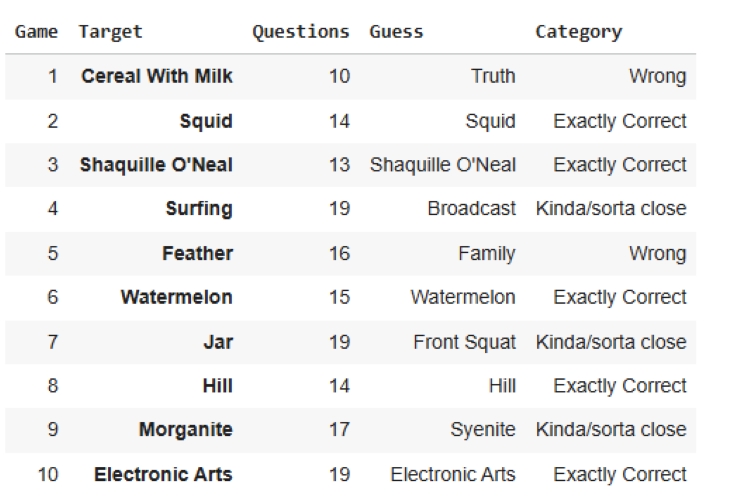

## Future Work and Limitations